# **Regression**

## Objectives

* Fit and evaluate a regression model to predict tomorrow's average stock price

## Inputs

* outputs/datasets/cleaned/phnx_2010_2025.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict tomorrows_average
* Feature Importance Plot

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\ajv10\\Documents\\vscode-projects\\PP5\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\ajv10\\Documents\\vscode-projects\\PP5'

---

## Load Data

Load the data and drop the categorical target

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/cleaned/phnx_2010_2025.csv")
      .drop(labels=['target'], axis=1))
print(df.shape)
df.head(3)

(3785, 21)


,year,weekday,open,high,low,close,volume,pre_open,pre_open_2,pre_high,...,pre_low,pre_low_2,pre_close,pre_close_2,pre_vol,pre_vol_2,pre_average,pre_average_2,average,tomorrows_average
0,2010,Wednesday,497.990021,497.990021,497.990021,497.990021,10729.0,507.246289,477.996320,510.282389,...,507.246289,477.996320,497.990021,497.990021,10729.0,13401.0,502.618155,487.993170,497.990021,505.506095
1,2010,Thursday,507.468427,507.468427,503.543762,503.543762,6169.0,497.990021,507.246289,497.990021,...,497.990021,507.246289,497.990021,497.990021,10729.0,10729.0,497.990021,502.618155,505.506095,503.543762
2,2010,Friday,503.543762,503.543762,503.543762,503.543762,6169.0,507.468427,497.990021,507.468427,...,503.543762,497.990021,503.543762,497.990021,6169.0,10729.0,505.506095,497.990021,503.543762,503.543762


---

## MP Pipeline: Regressor

Create ML pipeline

In [5]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['weekday'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),
        ("feat_scaling", StandardScaler()),
        ("feat_selection",  SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base


In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['tomorrows_average'], axis=1),
    df['tomorrows_average'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (3028, 20) (3028,) 
* Test set: (757, 20) (757,)


In [8]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [9]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\ajv10\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


In [10]:

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
0,LinearRegression,0.973256,0.986151,0.99381,0.00723
5,GradientBoostingRegressor,0.972301,0.985421,0.99319,0.007385
2,RandomForestRegressor,0.959952,0.979554,0.990562,0.010881
3,ExtraTreesRegressor,0.954016,0.976515,0.988765,0.012491
4,AdaBoostRegressor,0.960998,0.975754,0.984977,0.008425
1,DecisionTreeRegressor,0.946451,0.972419,0.98755,0.014671
6,XGBRegressor,NaN,NaN,NaN,NaN


In [11]:
models_search = {
    "LinearRegression": LinearRegression(),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

# Documentation to help on hyperparameter list:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "LinearRegression": {
        'model__fit_intercept': [True, False],
        'model__copy_X': [True, False],
        'model__n_jobs': [-1, 1],
    },
     "GradientBoostingRegressor": {
        'model__loss': ['squared_error', 'absolute_error', 'huber'],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__n_estimators': [100, 200, 300],
        'model__subsample': [0.5, 0.8, 1.0],
        'model__min_samples_split': [2, 4, 6],
        'model__min_samples_leaf': [1, 2, 3],
        'model__max_depth': [2, 4, 6],
    },
}


In [12]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__copy_X,model__fit_intercept,model__n_jobs,model__learning_rate,model__loss,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__subsample
0,LinearRegression,0.973256,0.986151,0.99381,0.00723,True,True,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LinearRegression,0.973256,0.986151,0.99381,0.00723,True,True,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LinearRegression,0.973256,0.986151,0.99381,0.00723,False,True,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,LinearRegression,0.973256,0.986151,0.99381,0.00723,False,True,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1280,GradientBoostingRegressor,0.973042,0.985787,0.993714,0.007229,NaN,NaN,NaN,0.05,huber,2,3,2,200,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,GradientBoostingRegressor,0.645061,0.678084,0.704921,0.021567,NaN,NaN,NaN,0.01,absolute_error,2,1,2,100,0.5
3,LinearRegression,-32.935778,-30.80789,-28.063136,1.671656,True,False,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,LinearRegression,-32.935778,-30.80789,-28.063136,1.671656,False,False,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LinearRegression,-32.935778,-30.80789,-28.063136,1.671656,True,False,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:

best_model = grid_search_summary.iloc[0, 0]
best_model

'LinearRegression'

In [15]:

parameters_regressor = grid_search_pipelines[best_model].best_params_
parameters_regressor

{'model__copy_X': True, 'model__fit_intercept': True, 'model__n_jobs': -1}

In [16]:
pipeline_regressor = grid_search_pipelines[best_model].best_estimator_
pipeline_regressor

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['weekday'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=LinearRegression())),
                ('model', LinearRegression(n_jobs=-1))])

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


if best_model != 'LinearRegression':
    # after data cleaning and feature engineering, the features may have changes
    # how many data cleaning and feature engineering steps does your pipeline have?
    data_cleaning_feat_eng_steps = 2
    columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_regressor.steps[:data_cleaning_feat_eng_steps])
                                            .transform(X_train)
                                            .columns)

    best_features = columns_after_data_cleaning_feat_eng[pipeline_regressor['feat_selection'].get_support(
    )].to_list()

    # create DataFrame to display feature importance
    df_feature_importance = (pd.DataFrame(data={
        'Feature': columns_after_data_cleaning_feat_eng[pipeline_regressor['feat_selection'].get_support()],
        'Importance': pipeline_regressor['model'].feature_importances_})
        .sort_values(by='Importance', ascending=False)
    )

    # Most important features statement and plot
    print(f"* These are the {len(best_features)} most important features in descending order. "
        f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

    df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
    plt.show()


* These are the 1 most important features in descending order. The model was trained on them: 
['high']


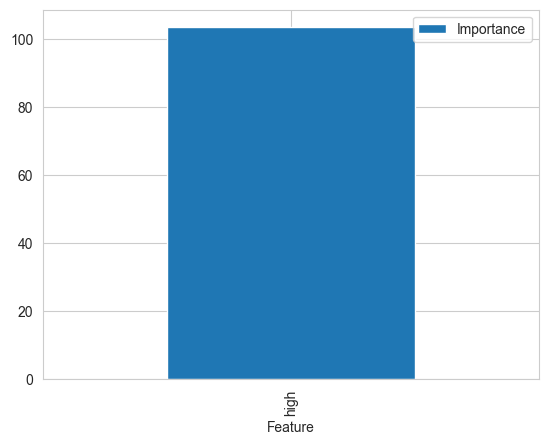

In [18]:

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_regressor.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[pipeline_regressor['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_regressor['feat_selection'].get_support()],
    'Importance': np.abs(pipeline_regressor['model'].coef_)})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


In [19]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', np.round(r2_score(y, prediction), 3))
    print('Mean Absolute Error:', np.round(mean_absolute_error(y, prediction), 3))
    print('Mean Squared Error:', np.round(mean_squared_error(y, prediction), 3))
    print('Root Mean Squared Error:', np.round(np.sqrt(
        mean_squared_error(y, prediction)), 3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Model Evaluation 

* Train Set
R2 Score: 0.992
Mean Absolute Error: 6.158
Mean Squared Error: 81.879
Root Mean Squared Error: 9.049


* Test Set
R2 Score: 0.994
Mean Absolute Error: 5.962
Mean Squared Error: 71.845
Root Mean Squared Error: 8.476




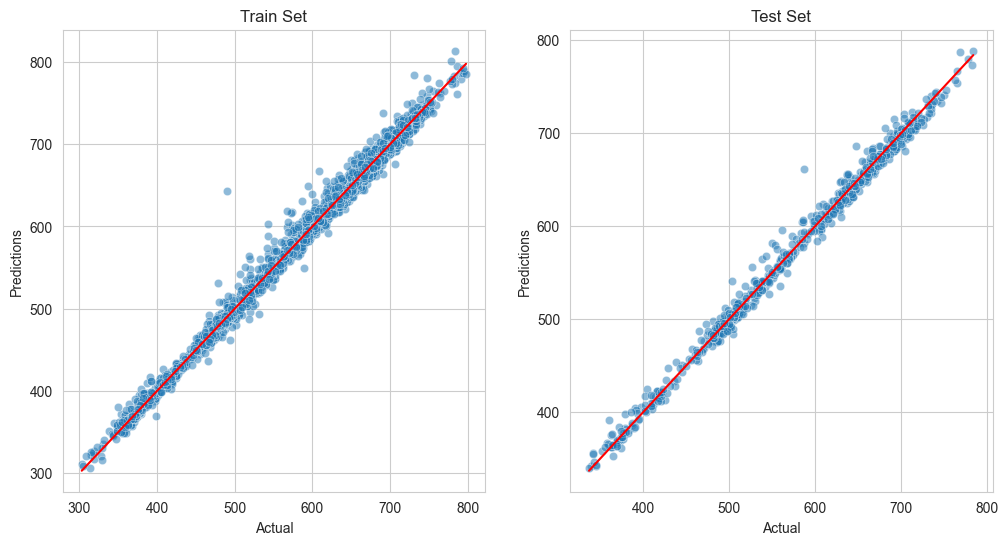

In [20]:
regression_performance(X_train, y_train, X_test, y_test, pipeline_regressor)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            pipeline_regressor)

---

## Regressor with PCA

In [21]:

pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:3])
df_pca = pipeline_pca.fit_transform(df.drop(['tomorrows_average'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

(3785, 3) 
 <class 'numpy.ndarray'>


* The 3 components explain 100.0% of the data 



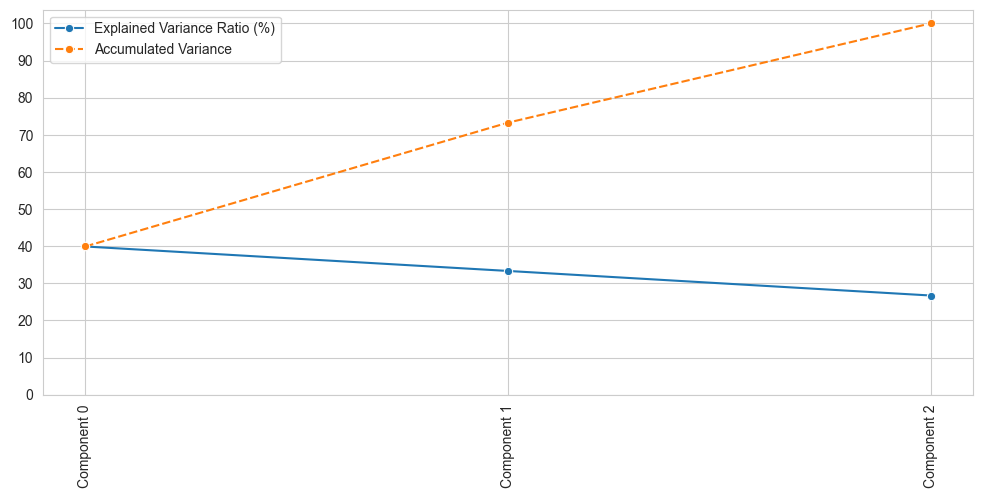

In [22]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 3


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)


* The 2 components explain 73.27% of the data 



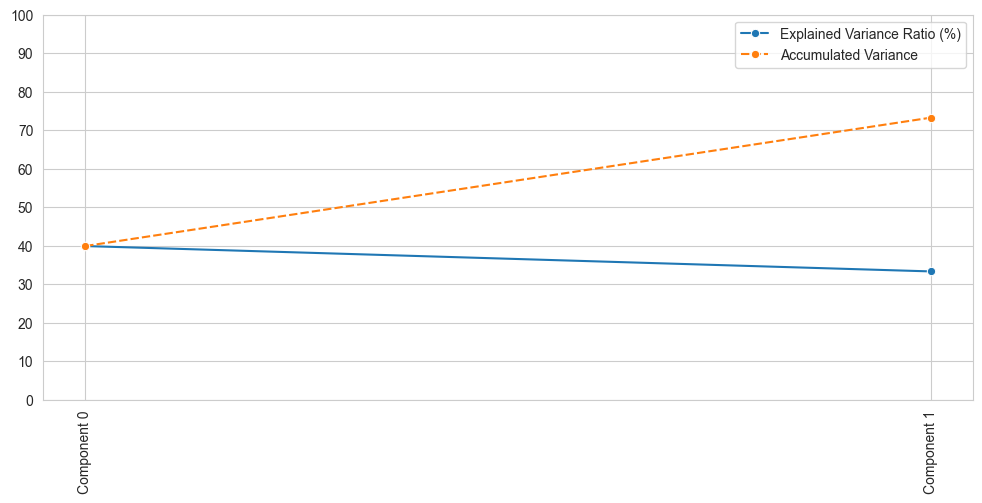

In [23]:
n_components = 2
pca_components_analysis(df_pca=df_pca, n_components=n_components)

We found that using two components would cause the model to overfit, resulting in a less accurate test set. Therefore, we used all three components

In [24]:
# PCA
from sklearn.decomposition import PCA


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['weekday'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),


        ("feat_scaling", StandardScaler()),

        # PCA replace Feature Selection
        ("PCA", PCA(n_components=3, random_state=0)),

        ("model", model),

    ])

    return pipeline_base


In [25]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (3028, 20) (3028,) 
* Test set: (757, 20) (757,)


In [26]:
models_quick_search_pca = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search_pca = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [27]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search_pca, params=params_quick_search_pca)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\ajv10\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


In [28]:
grid_search_summary_pca, grid_search_pipelines_pca = quick_search.score_summary(sort_by='mean_score')
grid_search_summary_pca

,estimator,min_score,mean_score,max_score,std_score
0,LinearRegression,0.973483,0.986234,0.99382,0.007155
3,ExtraTreesRegressor,0.964818,0.980963,0.990351,0.009293
5,GradientBoostingRegressor,0.967256,0.980483,0.99051,0.008394
2,RandomForestRegressor,0.966377,0.980363,0.989405,0.008053
1,DecisionTreeRegressor,0.942104,0.96397,0.981154,0.012643
4,AdaBoostRegressor,0.935493,0.945028,0.951317,0.007108
6,XGBRegressor,NaN,NaN,NaN,NaN


In [29]:
models_search_pca = {
    'LinearRegression': LinearRegression(),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

# Documentation for ExtraTreesRegressor hyperparameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html

params_search_pca = {
    "LinearRegression": {
        'model__fit_intercept': [True, False],
        'model__copy_X': [True, False],
        'model__n_jobs': [-1],
    },
    "ExtraTreesRegressor": {
        'model__n_estimators': [100, 300, 400, 500],
        'model__max_depth': [2, 5, 10, 15],
        'model__min_samples_split': [2, 4, 5, 6],
        'model__min_samples_leaf': [1, 2, 3],
        'model__max_features': ['sqrt', 'log2', None],
        'model__bootstrap': [True, False],
        'model__n_jobs': [-1],
    }
}

In [30]:
search = HyperparameterOptimizationSearch(models=models_search_pca, params=params_search_pca)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


In [31]:
grid_search_summary_pca, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary_pca

,estimator,min_score,mean_score,max_score,std_score,model__copy_X,model__fit_intercept,model__n_jobs,model__bootstrap,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,LinearRegression,0.973483,0.986234,0.99382,0.007155,True,True,-1,NaN,NaN,NaN,NaN,NaN,NaN
2,LinearRegression,0.973483,0.986234,0.99382,0.007155,False,True,-1,NaN,NaN,NaN,NaN,NaN,NaN
1122,ExtraTreesRegressor,0.968953,0.982914,0.990926,0.008024,NaN,NaN,-1,False,15,None,1,6,400
1120,ExtraTreesRegressor,0.968866,0.9829,0.990891,0.00799,NaN,NaN,-1,False,15,None,1,6,100
1123,ExtraTreesRegressor,0.968937,0.98289,0.990903,0.007998,NaN,NaN,-1,False,15,None,1,6,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,ExtraTreesRegressor,0.13428,0.148284,0.164797,0.011004,NaN,NaN,-1,False,2,log2,3,6,100
668,ExtraTreesRegressor,0.13428,0.148284,0.164797,0.011004,NaN,NaN,-1,False,2,log2,3,5,100
660,ExtraTreesRegressor,0.13428,0.148284,0.164797,0.011004,NaN,NaN,-1,False,2,log2,3,2,100
1,LinearRegression,-32.929142,-30.805471,-28.063571,1.669587,True,False,-1,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
best_model_pca = grid_search_summary.iloc[0,0]
best_model_pca

'LinearRegression'

In [33]:
parameters_regressor_pca = grid_search_pipelines[best_model_pca].best_params_
parameters_regressor_pca

{'model__copy_X': True, 'model__fit_intercept': True, 'model__n_jobs': -1}

In [34]:
pipeline_regressor_pca = grid_search_pipelines[best_model_pca].best_estimator_
pipeline_regressor_pca

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['weekday'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('PCA', PCA(n_components=3, random_state=0)),
                ('model', LinearRegression(n_jobs=-1))])

Model Evaluation 

* Train Set
R2 Score: 0.992
Mean Absolute Error: 6.16
Mean Squared Error: 81.708
Root Mean Squared Error: 9.039


* Test Set
R2 Score: 0.994
Mean Absolute Error: 5.95
Mean Squared Error: 71.399
Root Mean Squared Error: 8.45




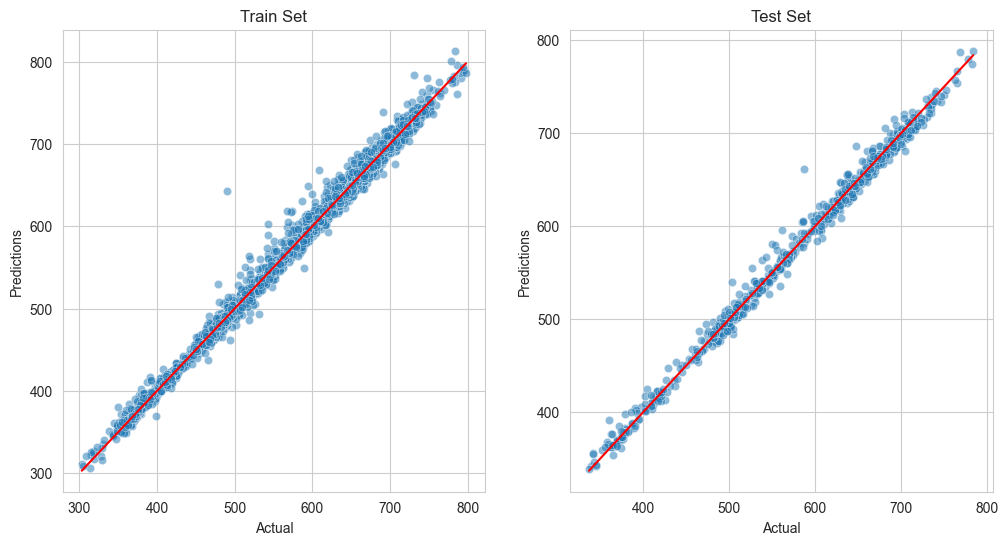

In [35]:
regression_performance(X_train, y_train, X_test, y_test, pipeline_regressor_pca)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            pipeline_regressor_pca)

---

## Which pipeline to choose?

In [36]:
pipeline_regressor

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['weekday'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=LinearRegression())),
                ('model', LinearRegression(n_jobs=-1))])

---

## Refit Pipeline with Best Features

Rewrite Pipeline

In [37]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
        #                                              variables=['weekday'])),

        ("feat_scaling", StandardScaler()),

        # feature selection is not needed

        ("model", model),

    ])

    return pipeline_base


In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['tomorrows_average'], axis=1),
    df['tomorrows_average'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (3028, 20) (3028,) 
* Test set: (757, 20) (757,)


In [39]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (3028, 1) (3028,) 
* Test set: (757, 1) (757,)


,high
628,372.016645
883,503.042913
330,480.958363


### Grid Search CV – Sklearn

In [44]:
best_model

'LinearRegression'

In [50]:
models_search = {
    "LinearRegression": LinearRegression()
}

In [51]:
parameters_regressor

{'model__copy_X': True, 'model__fit_intercept': True, 'model__n_jobs': -1}

In [52]:
params_search = {
    "LinearRegression": {
        'model__fit_intercept': [True],
        'model__copy_X': [True],
        'model__n_jobs': [-1],
    }
    }

In [53]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [54]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__copy_X,model__fit_intercept,model__n_jobs
0,LinearRegression,0.989741,0.992372,0.99381,0.001419,True,True,-1


In [55]:
best_model = grid_search_summary.iloc[0,0]
best_model

'LinearRegression'

In [56]:
pipeline_regressor = grid_search_pipelines[best_model].best_estimator_
pipeline_regressor

Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('model', LinearRegression(n_jobs=-1))])

* These are the 1 most important features in descending order. The model was trained on them: 
['high']


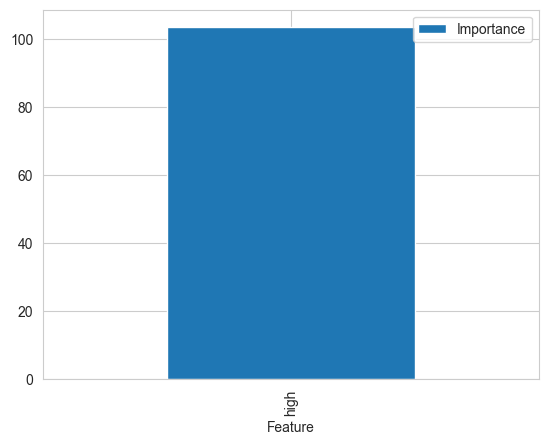

In [69]:
# How many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 1

# Apply the pipeline steps to X_train
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_regressor.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train))

# If the transformation results in only one feature, handle it accordingly

best_features = X_train.columns

# Create DataFrame to display feature importance
df_feature_importance = pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_regressor['model'].coef_,
}).sort_values(by='Importance', ascending=False)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


In [71]:
regression_performance(X_train, y_train, X_test, y_test, pipeline_regressor)


Model Evaluation 

* Train Set
R2 Score: 0.992
Mean Absolute Error: 6.158
Mean Squared Error: 81.879
Root Mean Squared Error: 9.049


* Test Set
R2 Score: 0.994
Mean Absolute Error: 5.962
Mean Squared Error: 71.845
Root Mean Squared Error: 8.476




---

# Push files to Repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* features importance plot

In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_tomorrows_avg/{version}'

try:
  os.makedirs(name=file_path)
  print(f"directory {file_path} created")
except Exception as e:
  print(e)

directory outputs/ml_pipeline/predict_tomorrows_average/v1 created


### Train Set: features and target

In [100]:
X_train.head()

,high
628,372.016645
883,503.042913
330,480.958363
1423,664.755318
2581,501.017987


In [101]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)
print(f"train set saved to {file_path}/X_train.csv")

train set saved to outputs/ml_pipeline/predict_tomorrows_average/v1/X_train.csv


In [102]:
y_train

628     364.976316
883     498.480261
330     487.437813
1423    657.715720
2581    520.206674
           ...    
835     486.883272
3264    606.641988
1653    592.260697
2607    586.634148
2732    662.296038
Name: tomorrows_average, Length: 3028, dtype: float64

In [103]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)
print(f"train set saved to {file_path}/y_train.csv")

train set saved to outputs/ml_pipeline/predict_tomorrows_average/v1/y_train.csv


### Test Set: features and target

In [104]:

X_test.head()

,high
538,421.517826
526,438.926790
2216,633.165649
3658,535.487322
776,486.693146


In [105]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)
print(f"test set saved to {file_path}/X_test.csv")

test set saved to outputs/ml_pipeline/predict_tomorrows_average/v1/X_test.csv


In [106]:
y_test

538     418.554547
526     435.778325
2216    619.217202
3658    531.740952
776     481.940238
           ...    
1032    558.936646
3418    555.894333
548     408.924184
3651    518.753353
245     462.815954
Name: tomorrows_average, Length: 757, dtype: float64

In [107]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)
print(f"test set saved to {file_path}/y_test.csv")

test set saved to outputs/ml_pipeline/predict_tomorrows_average/v1/y_test.csv


### Modelling pipeline

In [108]:
pipeline_regressor

Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('model', LinearRegression(n_jobs=-1))])

In [109]:
joblib.dump(value=pipeline_regressor, filename=f"{file_path}/regressor_pipeline.pkl")

['outputs/ml_pipeline/predict_tomorrows_average/v1/regressor_pipeline.pkl']

### Feature importance plot

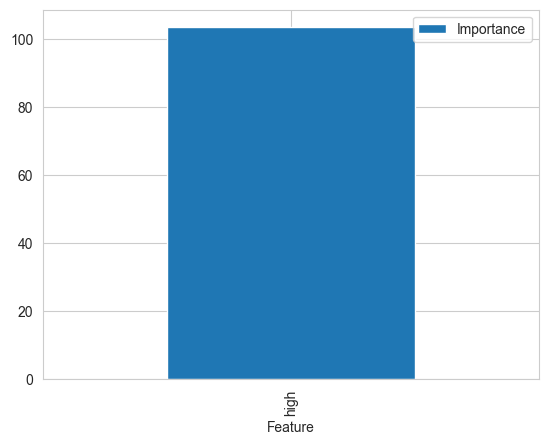

In [110]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

plot saved


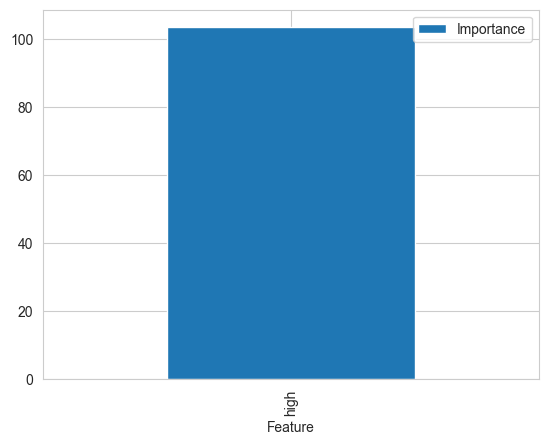

In [111]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')
print('plot saved')